<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN_Emotion_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/My\ Drive/Colab\ Notebooks/
!ls
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from idlmam  import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [14]:
import unicodedata
import string
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

print("importing the relevant modules")

importing the relevant modules


In [ ]:
!pip install datasets
print("download dataset to import it later on")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [57]:

from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions")

print(dataset)
label_mapping = dataset["train"].features["labels"].feature.names
print(label_mapping)


print("importing the go_emotions dataset and printint the dataset out to check format of dataset")

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
importing the go_emotions dataset and printint the dataset out to check format of dataset


In [58]:
emotion_data = {}


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
  alphabet[all_letters[i]] = i


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print()
print("training_data")

for sample in dataset["train"]:
    text = sample["text"]
    labels = sample["labels"]

    normalized_text = unicodeToAscii(text).lower()

    for label in labels:
        emotion = label_mapping[label]

        if emotion not in emotion_data:
            emotion_data[emotion] = []
        emotion_data[emotion].append(normalized_text)

for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")



training_data
neutral: 14219 samples
anger: 1567 samples
fear: 596 samples
annoyance: 2470 samples
surprise: 1060 samples
gratitude: 2662 samples
desire: 641 samples
optimism: 1581 samples
admiration: 4130 samples
confusion: 1368 samples
amusement: 2328 samples
approval: 2939 samples
caring: 1087 samples
embarrassment: 303 samples
realization: 1110 samples
disappointment: 1269 samples
grief: 77 samples
sadness: 1326 samples
curiosity: 2191 samples
joy: 1452 samples
love: 2086 samples
excitement: 853 samples
disapproval: 2022 samples
remorse: 545 samples
disgust: 793 samples
relief: 153 samples
pride: 111 samples
nervousness: 164 samples


In [15]:
class EmotionTextDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
              if len(sample) > 0:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """

        T = len(input_string)

        name_vec = torch.zeros((T), dtype=torch.long)
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [17]:
import torch
from torch.utils.data import DataLoader, random_split


dataset = EmotionTextDataset(emotion_data, alphabet)

#To split the dataset for training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")



Training data size: 40880
Testing data size: 10220


In [ ]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)



torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.7742, -0.4913],
        [ 0.8924,  0.9729],
        [ 0.8924,  0.9729],
        [ 0.7742, -0.4913],
        [ 2.1029,  0.0535]])


In [18]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):

        rnn_output = input[0]
        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]

        batch_size = last_step.shape[1]
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        last_step = last_step[self.rnn_layers-1]
        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)


In [ ]:
def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0])

    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    return x_packed, y_batched


In [ ]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects.
    This wrapper class will fix that. If a normal input comes in, it will
    use the regular Embedding layer. Otherwise, it will work on the packed
    sequence to return a new Packed sequence of the appropriate result.
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            sequences = self.embd_layer(sequences.to(input.data.device))
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(),
                                                           batch_first=True, enforce_sorted=False)
        else:
            return self.embd_layer(input)



In [ ]:
#for 1 batch

D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D),
  nn.RNN(D, hidden_nodes, batch_first=True),
  LastTimeStep(),
  nn.Linear(hidden_nodes, classes),
)

loss_func = nn.CrossEntropyLoss()
device = "cuda"
batch_one_train = train_simple_network(first_rnn, \
              loss_func, train_loader, \
              test_loader=test_loader, \
              score_funcs={'Accuracy': accuracy_score},\
              device=device, epochs=5)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/40880 [00:00<?, ?it/s]

Testing:   0%|          | 0/10220 [00:00<?, ?it/s]

Training:   0%|          | 0/40880 [00:00<?, ?it/s]

Testing:   0%|          | 0/10220 [00:00<?, ?it/s]

Training:   0%|          | 0/40880 [00:00<?, ?it/s]

Testing:   0%|          | 0/10220 [00:00<?, ?it/s]

Training:   0%|          | 0/40880 [00:00<?, ?it/s]

Testing:   0%|          | 0/10220 [00:00<?, ?it/s]

Training:   0%|          | 0/40880 [00:00<?, ?it/s]

Testing:   0%|          | 0/10220 [00:00<?, ?it/s]

In [ ]:
# for 16 batch size

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, batch_first=True),
  LastTimeStep(),
  nn.Linear(hidden_nodes, classes),
)

rnn_packed.to(device)

loss_func = nn.CrossEntropyLoss()
device = "cuda"

packed_train = train_simple_network(rnn_packed, loss_func, \
                                    train_loader, \
                                    test_loader=test_loader, \
                                    score_funcs={'Accuracy': \
                                                 accuracy_score}, \
                                    device=device, epochs=10)




Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
# for 3 layers

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True),
  LastTimeStep(rnn_layers=3),
  nn.Linear(hidden_nodes, classes),
)

rnn_3layer.to(device)
rnn_3layer_results = train_simple_network(
    rnn_3layer,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=20,
    lr=0.01
)



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
#For biderectional batch size = 16 number of layers =3

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, classes),
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                lr=0.01)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
B = 16

train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, classes),
)

In [ ]:
# manually saving the RNN model because i forgot to define it just now

checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch.pth'
optimizer = torch.optim.SGD(rnn_3layer_bidir.parameters(), lr=0.01)

torch.save({
    'epoch': 20,
    'model_state_dict': rnn_3layer_bidir.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': rnn_3layer_bidir_results
}, checkpoint_file)

print(f"Checkpoint saved at: {checkpoint_file}")


Checkpoint saved at: /content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch.pth


This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD
Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.
It also seemed like the model could be even more accurate based on the graph if given more epochs


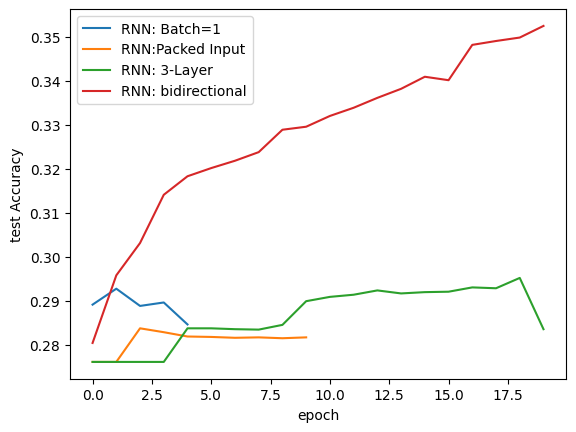

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train,label='RNN: Batch=1')
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train,label='RNN:Packed Input')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='RNN: 3-Layer')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results, label='RNN: bidirectional')
print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



In [23]:
#This function loads the checkpoint file for the bidirectional RNN and helps me save time as I don't have to run everything again


def load_checkpoint(checkpoint_file, model, optimizer):
    """Load model and optimizer state from checkpoint."""
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    results = checkpoint['results']

    return epoch, results


In [ ]:
# Load the checkpoint
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch.pth'
checkpoint_dict = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint_dict['model_state_dict'])
optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])

start_epoch = checkpoint_dict['epoch']

loaded_results = pd.DataFrame(checkpoint_dict['results'])

print(f"Checkpoint loaded successfully from epoch {start_epoch}")


Checkpoint loaded successfully from epoch 20


<ipython-input-30-0656b399d62b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint_path, map_location=device)


In [ ]:
#try using adam to see if model acc improves
def train_simple_network_Adam(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0
    results = {}

    for item in to_track:
        results[item] = []

    #Using Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
#try using adamw (improved version of adam) to see if model acc improves
def train_simple_network_Adamw(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    #Using AdamW
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
#try RMSpop
def train_simple_network_RMSpop(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    #Using RMSpop
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
# For bidirectional RNN using Adam
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_Adam.pth'

rnn_3layer_bidir = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
    LastTimeStep(rnn_layers=3, bidirectional=True),
    nn.Linear(hidden_nodes * 2, classes)
)

rnn_3layer_bidir.to(device)

rnn_3layer_bidir_results = train_simple_network_Adam(
    rnn_3layer_bidir,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=30,
    lr=0.01,
    checkpoint_file=checkpoint_file
)


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
# For bidirectional RNN using AdamW with 30 epoch
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_Adamw.pth'

# Define the bidirectional RNN model
rnn_3layer_bidir = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),  # (B, T, D) -> ( (B,T,D), (S, B, D) )
    LastTimeStep(rnn_layers=3, bidirectional=True),
    nn.Linear(hidden_nodes * 2, classes)
)

rnn_3layer_bidir.to(device)

rnn_3layer_bidir_results = train_simple_network_Adamw(
    rnn_3layer_bidir,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=30,
    lr=0.01,
    checkpoint_file=checkpoint_file
)


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
# For bidirectional RNN using RMSpop
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch_RMSpop.pth'

rnn_3layer_bidir = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),  # (B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),  # (B, T, D) -> ( (B,T,D), (S, B, D) )
    LastTimeStep(rnn_layers=3, bidirectional=True),  # Reduce RNN output to (B, D)
    nn.Linear(hidden_nodes * 2, classes)  # (B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)

rnn_3layer_bidir_results = train_simple_network_RMSpop(
    rnn_3layer_bidir,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=30,
    lr=0.01,
    checkpoint_file=checkpoint_file
)



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [ ]:
#Training SGD with 30 epochs

D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
B = 16
checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_SGD.pth'

train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=30, \
                                                checkpoint_file=checkpoint_file, \
                                                lr=0.01)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

<ipython-input-51-7abf0f2a72f9>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(path, map_location=device)
<ipython-input-51-7abf0f2a72f9>:18:

<Axes: xlabel='epoch', ylabel='test Accuracy'>

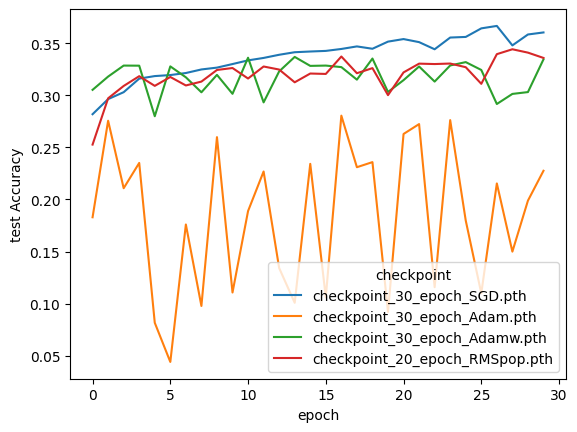

In [ ]:
#To plot out all 4 different optimizer performance

import seaborn as sns
import torch
import pandas as pd

checkpoint_paths = [
    '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_SGD.pth',
    '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_Adam.pth',
    '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_Adamw.pth',
    '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch_RMSpop.pth'
]

all_results = []

for path in checkpoint_paths:
    checkpoint_dict = torch.load(path, map_location=device)

    start_epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model_state_dict'])  # Load model state
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])  # Load optimizer state
    loaded_results = pd.DataFrame(checkpoint_dict['results'])  # Convert to DataFrame

    loaded_results['checkpoint'] = path.split('/')[-1]

    all_results.append(loaded_results)

final_results = pd.concat(all_results, ignore_index=True)


sns.lineplot(x='epoch', y='test Accuracy', hue='checkpoint', data=final_results)

# Customize the plot



In [19]:
#tried using momentum
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.01):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    #Using learning rate 0.01 and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01,  momentum=0.9)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
#Training SGD with lower learning rate
#Because training with epoch 30 didn't really make much difference, I thought to lower the epoch to make the training time faster

D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
B = 16
checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch_lr=0.001'

train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                checkpoint_file=checkpoint_file, \
                                                lr=0.001)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [21]:
#Training SGD with momentum

D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
B = 16
checkpoint_file = '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_20_epoch_lr=0.01_momentum=0.9'

train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

loss_func = nn.CrossEntropyLoss()


rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, classes),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                checkpoint_file=checkpoint_file, \
                                                lr=0.01)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

Training:   0%|          | 0/2555 [00:00<?, ?it/s]

Testing:   0%|          | 0/639 [00:00<?, ?it/s]

In [37]:
#To plot out the confusion matrix for 30 epochs SGD as it has the best Accuracy
import torch

checkpoint_file = "/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_SGD.pth"

checkpoint = torch.load(checkpoint_file, map_location="cuda" if torch.cuda.is_available() else "cpu")

model = rnn_3layer_bidir
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


<ipython-input-37-71e875af3c42>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location="cuda" if torch.cuda.is_available() el

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=28, bias=True)
)

In [38]:
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


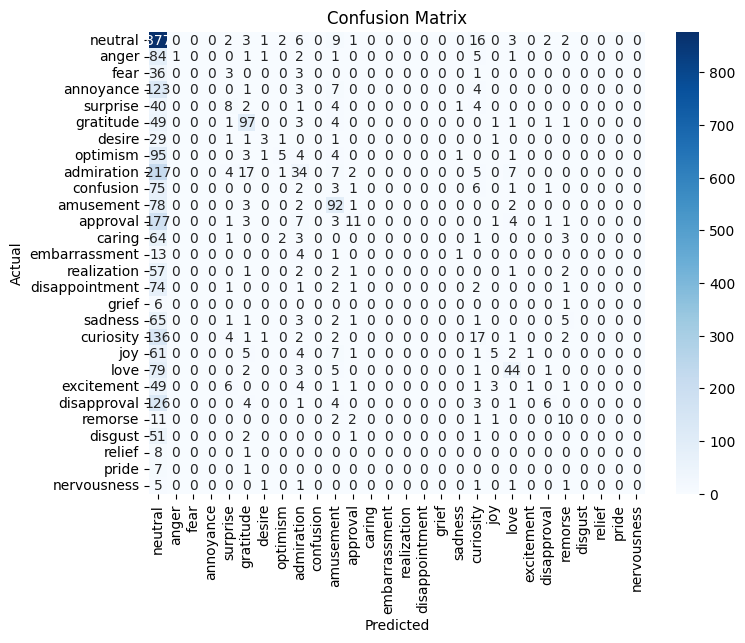

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.label_names, yticklabels=dataset.label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [52]:
#To see highest predited emotion output

import torch
import torch.nn.functional as F

checkpoint_file = "/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint_30_epoch_SGD.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_file, map_location=device)

D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, classes)
)

rnn_3layer_bidir.load_state_dict(checkpoint['model_state_dict'])

rnn_3layer_bidir.to(device)
rnn_3layer_bidir.eval()


input_string = "I hate this"

input_tensor = dataset.string2InputVec(input_string).reshape(1, -1)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    preds = F.softmax(rnn_3layer_bidir(input_tensor), dim=-1)

max_prob, max_index = torch.max(preds, dim=-1)

print(f"Predicted Emotion: {dataset.label_names[max_index.item()]} with {max_prob.item() * 100:.2f}% confidence")


Predicted Emotion: neutral with 21.30% confidence


<ipython-input-52-a55049ce7c07>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=device)
